In [112]:
import pandas as pd 
import numpy as np
from scipy.stats import chi2_contingency

import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.tree import plot_tree
import optuna
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import shap


### Carregar dados

In [10]:
df_employees = pd.read_csv('./datasets/data.csv',
                           parse_dates=['data_contratacao', 'data_demissao', 
                                        'data_ultimo_feedback', 'data_ultimo_aumento', 'data_ultima_mudanca_cargo'],
                                        date_format='%Y-%m-%d')

In [12]:
df_employees.head(10)

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0
5,EMP1053,49,Outro,Casado(a),Technical Degree,Híbrido,2020-01-08,NaT,NaN,Junior Developer,6507,2022-06-01,2020-07-05,2021-09-02,7.9,True,8,4,7.1,0
6,EMP1152,29,M,Casado(a),PhD,Presencial,2020-01-10,2022-08-22,Involuntária,Product Manager,12575,2020-10-16,2020-08-11,2022-02-27,9.1,True,6,3,1.9,1
7,EMP1317,38,F,Viúvo(a),PhD,Remoto,2020-01-11,NaT,NaN,DevOps Engineer,16643,2023-03-28,2023-05-16,2022-03-28,8.9,False,6,4,8.3,0
8,EMP1398,33,M,Casado(a),Technical Degree,Remoto,2020-01-12,NaT,NaN,DevOps Engineer,16771,2024-01-03,2024-03-13,2024-06-15,7.6,False,8,1,1.2,0
9,EMP0167,23,M,Viúvo(a),PhD,Híbrido,2020-01-13,NaT,NaN,QA Engineer,13258,2022-01-02,2021-09-15,2024-04-04,8.1,True,3,6,7.0,0


In [13]:
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

### Engenharia de features

In [14]:
#criar features baseadas em datas 
#calculo tempo de empresa
df_employees['tempo_empresa'] = df_employees.apply(lambda x:
                                                   (pd.Timestamp.now() - x['data_contratacao']).days if x['churn'] == 0
                                                   else (x['data_demissao'] - x['data_contratacao']).days, axis=1)

In [19]:
#calcular tempo desde o ultimo feedback
df_employees['dias_desde_ultimo_feedback'] = (pd.Timestamp.now() - df_employees['data_ultimo_feedback']).dt.days

In [21]:
#calcular tempo desde o ultimo aumento
df_employees['dias_desde_ultimo_aumento'] = (pd.Timestamp.now() - df_employees['data_ultimo_aumento']).dt.days

In [20]:
#calcular tempo desde o ultimo cargo
df_employees['dias_desde_ultimo_cargo'] = (pd.Timestamp.now() - df_employees['data_ultima_mudanca_cargo']).dt.days

In [24]:
#remover coluna ID
df_employees.drop(columns=['id'], axis=1, inplace=True)

### EDA

In [25]:
#verificação de valores ausentes
print('valores ausentes por coluna')
df_employees.isnull().sum()

valores ausentes por coluna


idade                            0
genero                           0
estado_civil                     0
educacao                         0
regime_trabalho                  0
data_contratacao                 0
data_demissao                 1714
tipo_demissao                 1714
cargo                            0
salario_atual                    0
data_ultimo_feedback             0
data_ultimo_aumento              0
data_ultima_mudanca_cargo        0
nota_avaliacao                   0
acompanhamento_psicologo         0
qtde_projetos                    0
qtde_clientes                    0
nivel_satisfacao_gestor          0
churn                            0
tempo_empresa                    0
dias_desde_ultimo_feedback       0
dias_desde_ultimo_cargo          0
dias_desde_ultimo_aumento        0
dtype: int64

In [26]:
#distribuição da variavel target em percentual

fig = px.bar(df_employees['churn'].value_counts()/len(df_employees)*100,
labels={'index': 'churn', 'value': 'percentual'})

fig.show()


In [30]:
#valores possiveis para variaveis categoricas
for col in df_employees.select_dtypes(include=['object']).columns:
    print(f'Valores unicos em {col}:')
    print(df_employees[col].unique())

Valores unicos em genero:
['F' 'Outro' 'M']
Valores unicos em estado_civil:
['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']
Valores unicos em educacao:
['Master' 'Technical Degree' 'Bachelor' 'PhD']
Valores unicos em regime_trabalho:
['Remoto' 'Híbrido' 'Presencial']
Valores unicos em tipo_demissao:
[nan 'Involuntária' 'Voluntária']
Valores unicos em cargo:
['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [33]:
#valores possiveis para variaveis numericas
df_employees.select_dtypes(include=['int64', 'float64']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_cargo,dias_desde_ultimo_aumento
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,1056.515000,716.89900,717.136500,730.005000
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,517.948402,395.59628,395.911115,397.623967
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.000000,230.00000,230.000000,231.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,620.000000,386.75000,390.750000,392.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,1058.000000,615.50000,607.000000,630.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1498.250000,956.25000,950.000000,989.250000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,1986.000000,1949.00000,1942.000000,1902.000000


In [36]:
#boxplot para variaveis numericas com churn
for col in df_employees.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'churn':
        fig = px.box(df_employees, x='churn', y=col, color='churn')
        fig.show()

In [40]:
#matrix de correlação
colunas_numericas = df_employees.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_employees[colunas_numericas].corr()

fig = px.imshow(corr_matrix,
                color_continuous_scale='Viridis',
                zmin=-1,
                zmax=1)
fig.update_layout(
    width=1200,
    height=1000,
    font=dict(size=9)
)
fig.update_traces(text=corr_matrix, texttemplate='%{text:.1%}', textfont={'size': 9})
fig.show()

In [39]:
#matrix de dispersao
fig = px.scatter_matrix(df_employees, dimensions=colunas_numericas,
                        color='churn')

fig.update_layout(
    width=1200,
    height=1000,
    font=dict(size=9)
)

fig.show()

In [41]:
#teste de hipoteses para variaveis categoricas vs churn
colunas_categoricas = df_employees.select_dtypes(include=['object']).columns
for col in colunas_categoricas:
    contingency_table = pd.crosstab(df_employees['churn'], df_employees[col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'Teste chi-q para {col} vs churn:')
    print(f'p-valor: {p_value}')
    if p_value <= 0.05:
        print(f'As variaveis {col} e churn nao sao independentes')
    else:
        print(f'As variaveis {col} e churn sao independentes')


Teste chi-q para genero vs churn:
p-valor: 0.6391382063144609
As variaveis genero e churn sao independentes
Teste chi-q para estado_civil vs churn:
p-valor: 0.8332629331272039
As variaveis estado_civil e churn sao independentes
Teste chi-q para educacao vs churn:
p-valor: 0.20475149121388256
As variaveis educacao e churn sao independentes
Teste chi-q para regime_trabalho vs churn:
p-valor: 0.9751275918764937
As variaveis regime_trabalho e churn sao independentes
Teste chi-q para tipo_demissao vs churn:
p-valor: 1.0
As variaveis tipo_demissao e churn sao independentes
Teste chi-q para cargo vs churn:
p-valor: 0.4586024122014406
As variaveis cargo e churn sao independentes


In [42]:
#graficos de barras para variaveis categoricas vs churn
for col in colunas_categoricas:
    fig = px.histogram(df_employees, x=col, color='churn', barmode='group')

    fig.show()

### Preparar dados

In [44]:
#separar features e target
colunas_data = list(df_employees.select_dtypes(include=['datetime64']).columns)

#x e y
X = df_employees.drop(['churn', 'tipo_demissao'] + colunas_data, axis=1)
y = df_employees['churn']

In [45]:
#criar preprocessador
#lista de colunas por tipo
features_numericas = X.select_dtypes(include=['int64', 'float64']).columns
features_categoricas = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ]
)

In [47]:
#dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=51, shuffle=True)

#aplicar colum transformer
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



### Treinar modelo - Baseline

In [48]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=51,
    max_features='sqrt',
    class_weight='balanced',
    

)

In [49]:
#treinar modelo
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Análise dos resultados baseline

In [50]:
#fazer predições (classificações - 0 ou 1)
y_pred = rf_model.predict(X_test)



In [51]:
#fazer predições (classificações - 0 ou 1)
y_pred_proba = rf_model.predict_proba(X_test)



In [52]:
y_pred_proba

array([[0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04],
       ...,
       [0.97, 0.03],
       [0.37, 0.63],
       [0.44, 0.56]])

In [53]:
#Avaliação do modelo
#relatorio de classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       855
           1       1.00      0.51      0.68       145

    accuracy                           0.93      1000
   macro avg       0.96      0.76      0.82      1000
weighted avg       0.93      0.93      0.92      1000



In [54]:
#retornar os valores da curva roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [55]:
#calcular o AUC
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [56]:
fig = px.area(
    x=fpr,
    y=tpr,
    labels=dict(x='False Positive', y='True Positive'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1)

fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1)

fig.show()

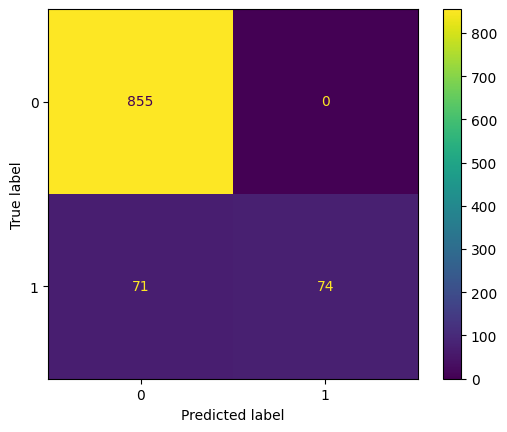

In [57]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [58]:
#calcular log loss
print(f'logloss: {log_loss(y_test, y_pred_proba):4f}')

logloss: 0.229591


### Treinar modelo com validação cruzada e tuning de hiperparametros

In [60]:
#criar um dicionario com os valores dos hiperparametros a serem testados
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [66]:
#configurar o gridseachCV com 5 folds 
rf_model_cv = RandomForestClassifier(class_weight='balanced', max_features='sqrt', random_state=51)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid, cv=kfolds, scoring='recall', verbose=2) 

In [67]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_de

,estimator,RandomForestC...ndom_state=51)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


#### usando o conveito de cross validate
#### X_train 50% = cross_validate = 4 partições para treino + 1 validação
#### gera o melhor modelo e validamos com X_test (50%)


### Análise de resultados - gridsearchcv

In [68]:
#retornar o melhor modelo
best_model = grid_search.best_estimator_

In [69]:
#retonrar melhores hiperparams
best_params = grid_search.best_params_

In [70]:
#apresentar hiper
best_params

{'max_depth': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 50}

In [71]:
#retonrar a melhor métrica
best_score = grid_search.best_score_

In [72]:
best_score

0.7172413793103448

### Análise dos resultados grisearch cv

In [73]:
#fazer predições (classificações - 0 ou 1)
y_pred = best_model.predict(X_test)



In [75]:
#fazer predições (classificações - 0 ou 1)
y_pred_proba = best_model.predict_proba(X_test)



In [76]:
y_pred_proba

array([[0.92290668, 0.07709332],
       [0.88009851, 0.11990149],
       [0.75997941, 0.24002059],
       ...,
       [0.85225537, 0.14774463],
       [0.25817641, 0.74182359],
       [0.40889477, 0.59110523]])

In [78]:
#Avaliação do modelo
#relatorio de classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       855
           1       0.99      0.69      0.81       145

    accuracy                           0.95      1000
   macro avg       0.97      0.84      0.89      1000
weighted avg       0.96      0.95      0.95      1000



In [79]:
#retornar os valores da curva roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [80]:
#calcular o AUC
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [81]:
fig = px.area(
    x=fpr,
    y=tpr,
    labels=dict(x='False Positive', y='True Positive'),
    width=700,
    height=500
)

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1)

fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1)

fig.show()

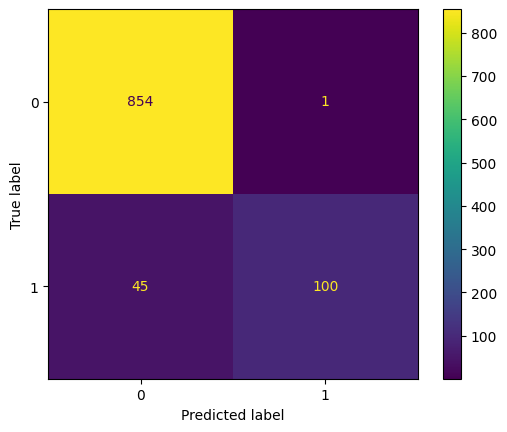

In [82]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [83]:
#calcular log loss
print(f'logloss: {log_loss(y_test, y_pred_proba):4f}')

logloss: 0.304575


### Ajustar threshold

In [85]:
#criar uma lista de thresholds para testar
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

#liesta para armazenar métrica
recalls = []

#Calcular as metricas para cada threshold
for threshold in thresholds:
    #fazer predição
    y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)

    #calcular metrica
    recall = recall_score(y_test, y_pred_threshold)

    #inserir métrica na lista
    recalls.append(recall)

In [86]:
#criar dataframe com resultados
df_thresholds = pd.DataFrame({'threshold': thresholds, 'recall': recalls})

In [87]:
df_thresholds.head(10)

,threshold,recall
0,0.3,0.903448
1,0.4,0.806897
2,0.5,0.689655
3,0.6,0.468966
4,0.7,0.289655


In [94]:
#encontrar o threshold com melhor recall
melhor_threshold = df_thresholds.loc[df_thresholds['recall'].idxmax()]
melhor_threshold

threshold    0.300000
recall       0.903448
Name: 0, dtype: float64

In [96]:
#plotar um grafico com threshold
fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=recalls, name='recall', line=dict(color='blue')))

fig.update_layout(
    xaxis_title='Threshold',
    yaxis_title='Recall Score',
    width=800,
    height=500
)

fig.show()

### Análise de métricas com threshold

In [97]:
y_pred = (y_pred_proba[:,1] >= melhor_threshold['threshold']).astype(int)

In [98]:
#Avaliação do modelo
#relatorio de classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       855
           1       0.47      0.90      0.62       145

    accuracy                           0.84      1000
   macro avg       0.73      0.87      0.76      1000
weighted avg       0.91      0.84      0.86      1000



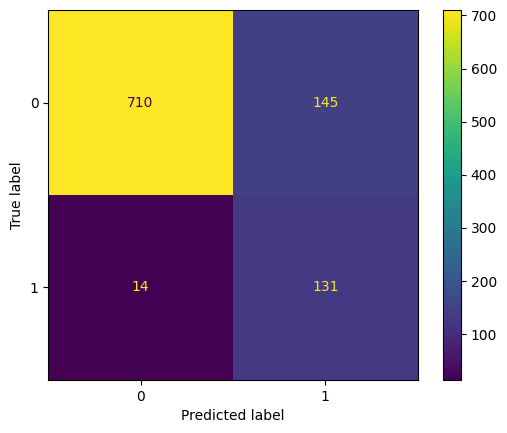

In [99]:
# Mostrar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

### Interpretabilidade

In [100]:
# Importancia das Variaveis
#obter a importancia
importancias = best_model.feature_importances_
nomes_features = preprocessor.get_feature_names_out()

#criar um dataframe
df_importancias = pd.DataFrame({'feature': nomes_features, 'importancia': importancias})

#ordenar o dataframe
df_importancias = df_importancias.sort_values('importancia', ascending=False).reset_index(drop=True)

In [ ]:
#plotar grafico com importancias
fig = px.bar(
    df_importancias.head(10),
    x='importancia',
    y='feature',
    orientation='h',
    color='importancia'   
)
fig.update_layout(
    height=600,
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()

In [110]:
#visualizar as arvores da random forest
#função para visualizar

def visualizar_arvore(modelo, indice_arvore, max_profundidade=5):
    plt.figure(figsize=(20,10))
    plot_tree(modelo.estimators_[indice_arvore],
              feature_names= nomes_features,
              class_names=['0', '1'],
              filled=True,
              rounded=True,
              max_depth= max_profundidade,
              fontsize=9,
              proportion=True,
              precision=2)
    plt.show()

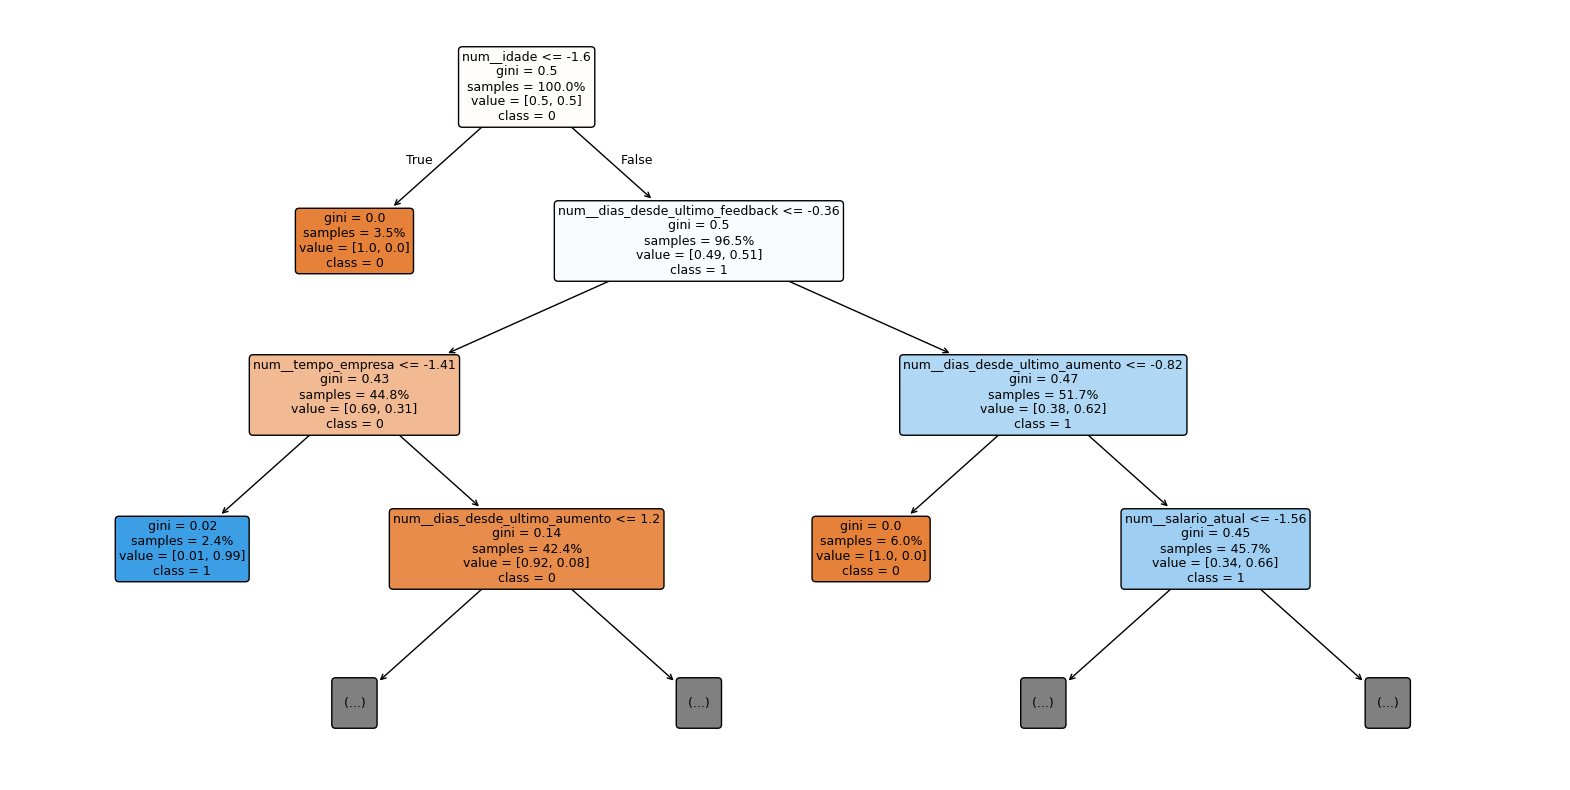

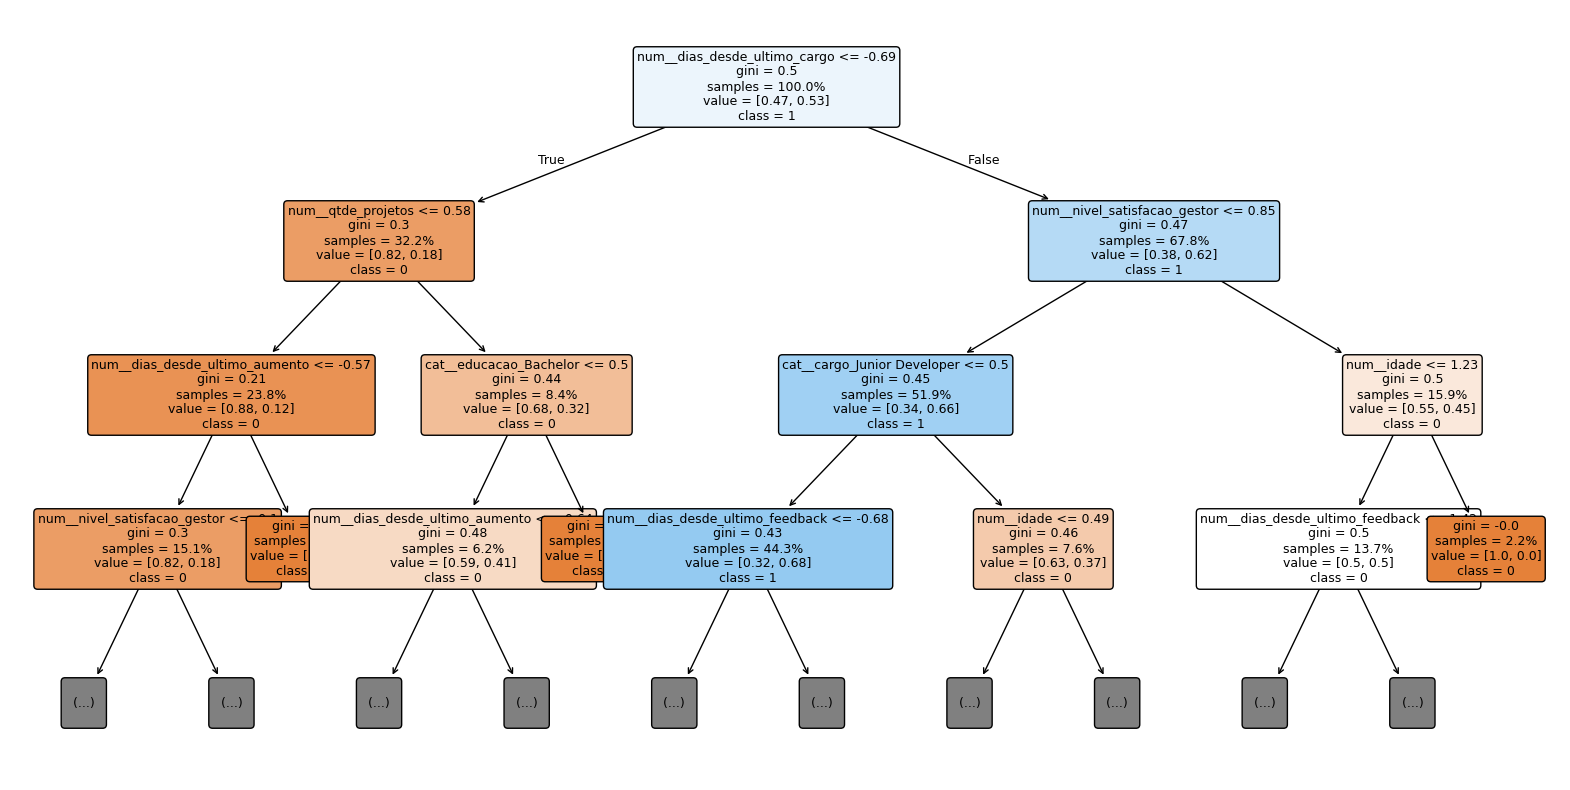

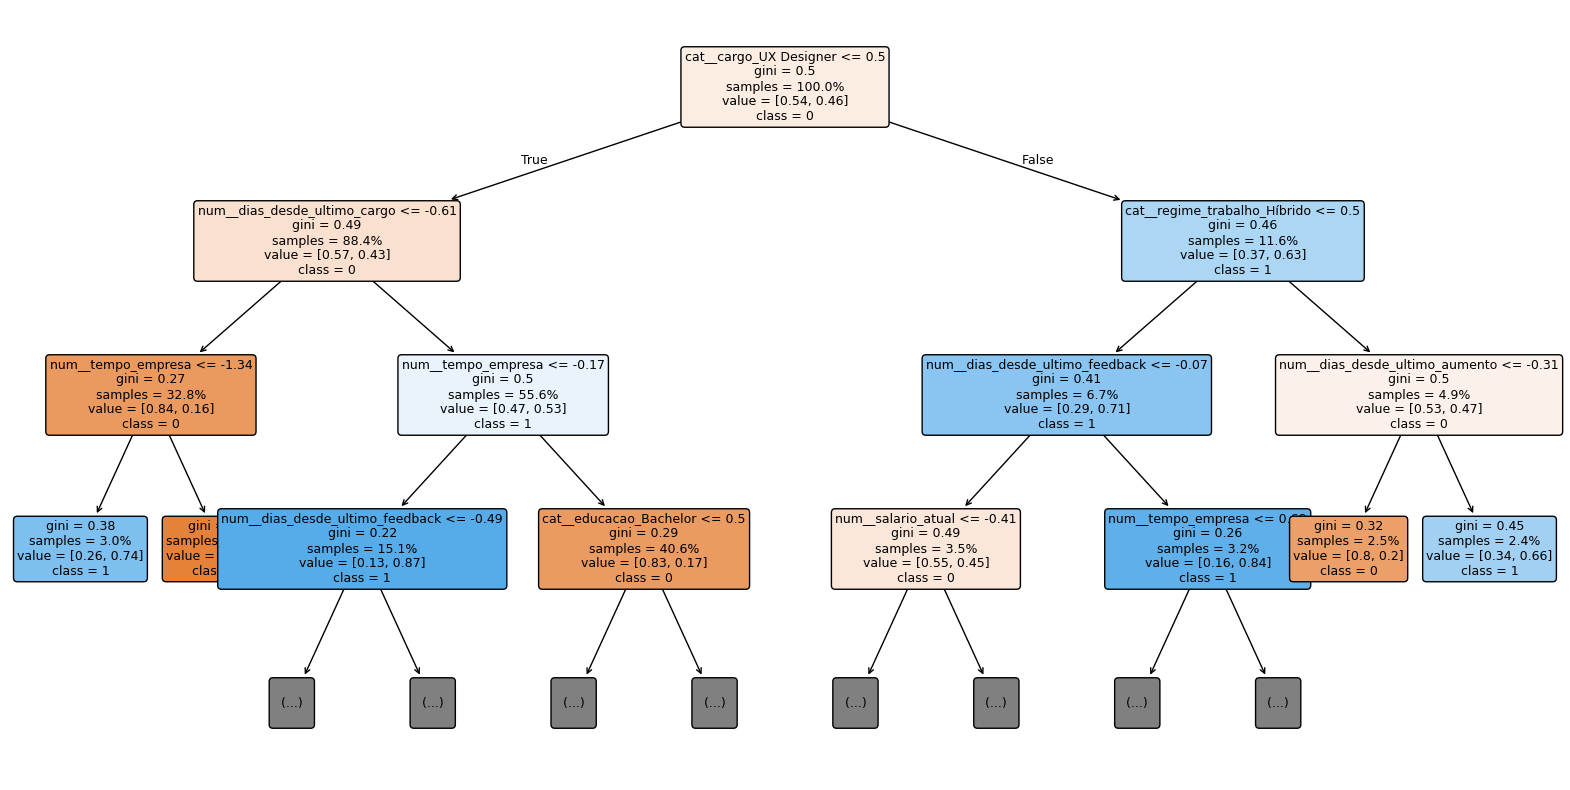

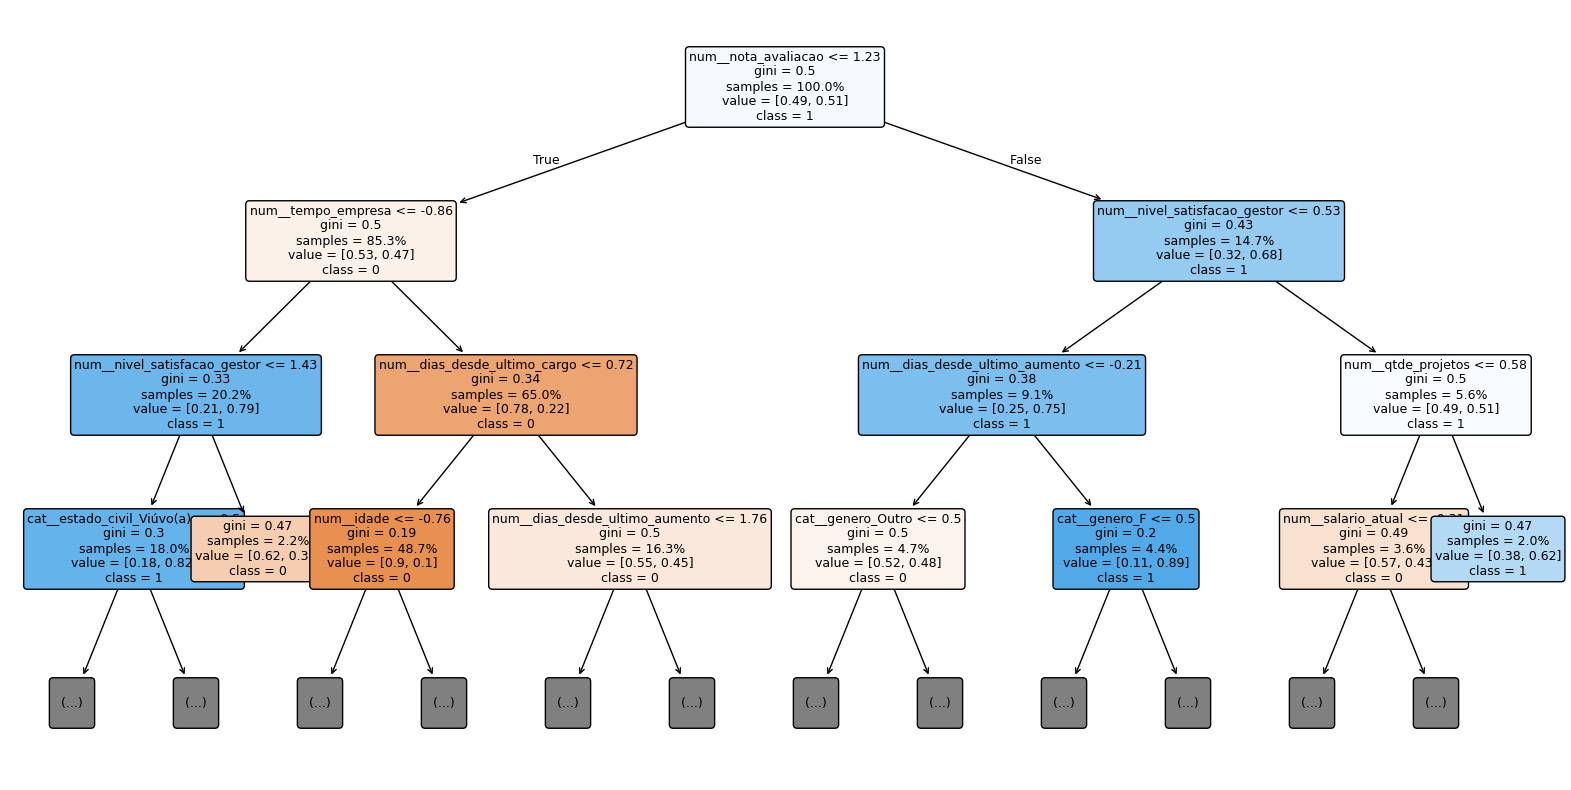

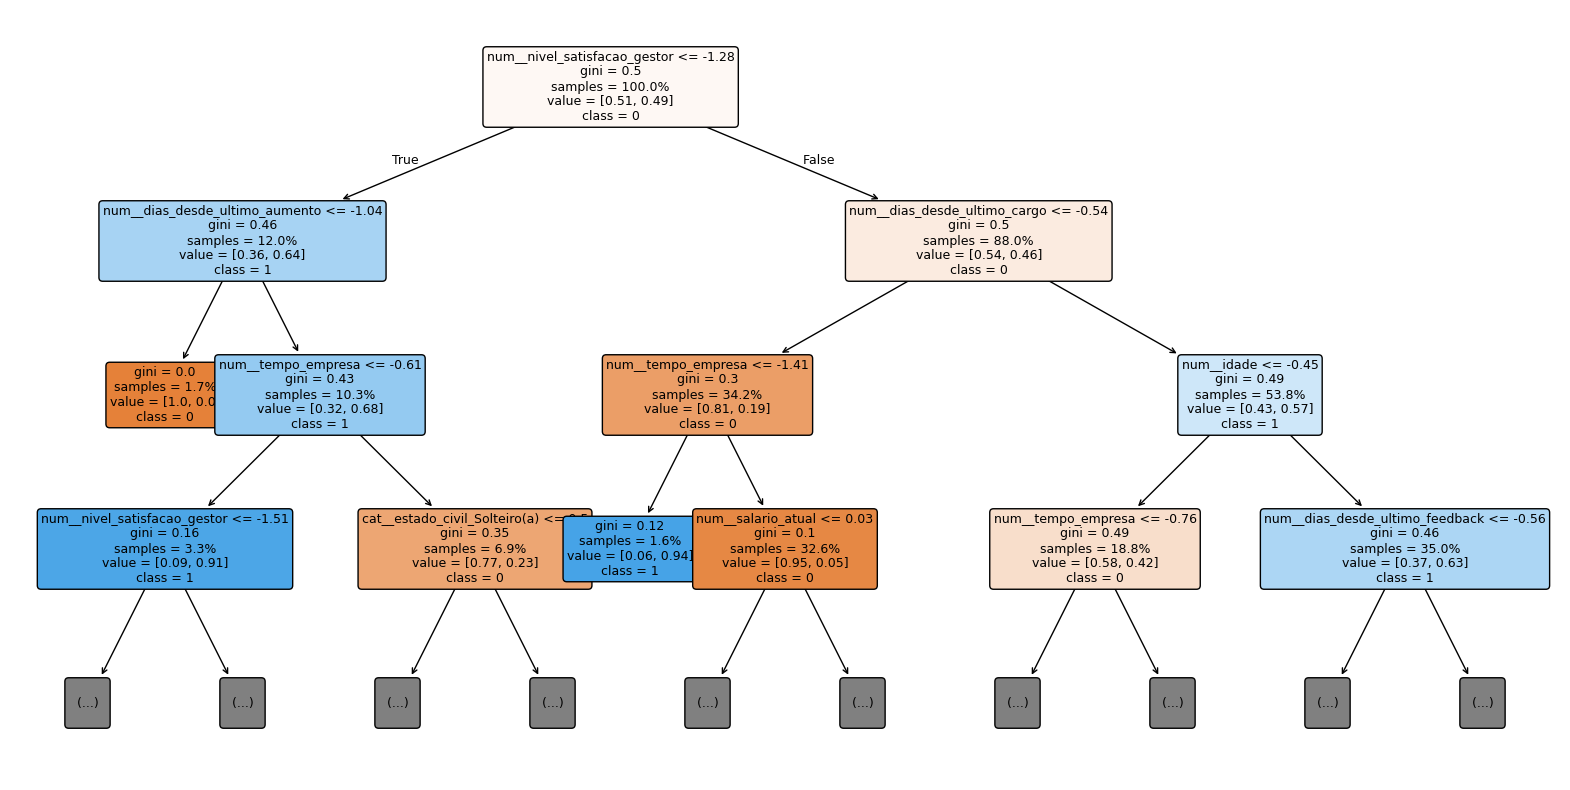

In [111]:
#visualizar 5 primeiras arvores
for i in range(5):
    visualizar_arvore(best_model, i, 3)

### Apresentar pltos shapley values

In [113]:
#rodar no conjunto de treinamento
explainer_class = shap.Explainer(best_model.predict, X_train, feature_names=nomes_features)

In [114]:
shap_values_class = explainer_class(X_test)

PermutationExplainer explainer: 1001it [01:28, 10.70it/s]                         


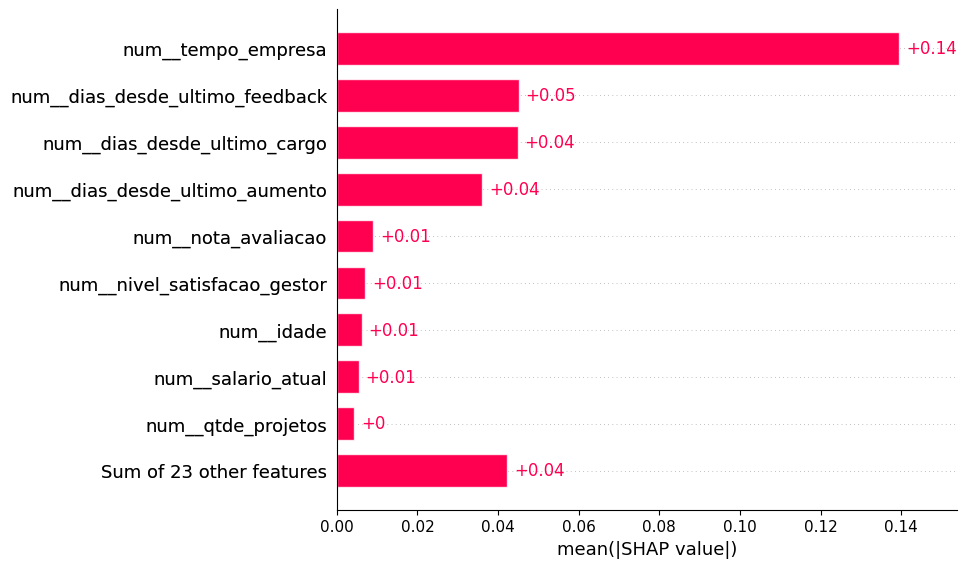

In [115]:
#plotar a contribuição global por shapley values
shap.plots.bar(shap_values_class)

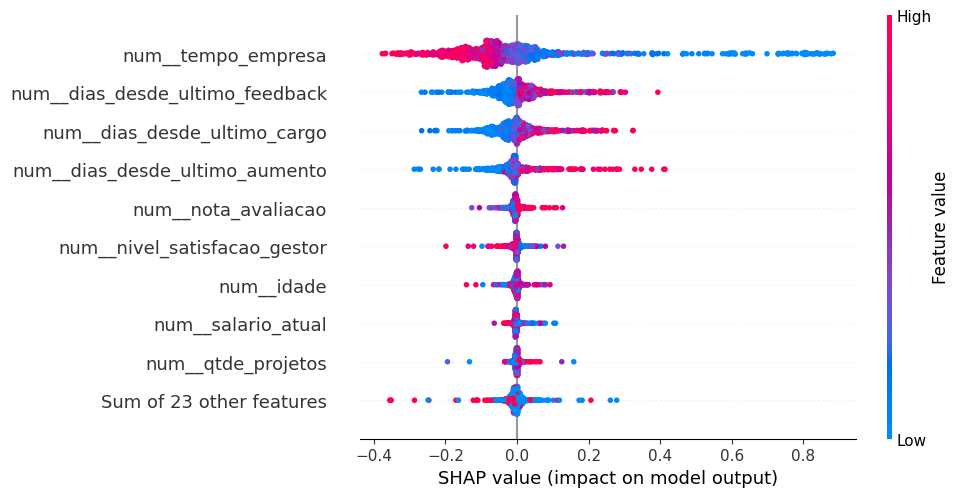

In [118]:
#plot de beeswarm global
shap.plots.beeswarm(shap_values_class, max_display=10)

In [119]:
#criar um dataframe contendo y_test e y_pred
df_comparacao = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [120]:
df_comparacao

,y_test,y_pred
1617,0,0
885,0,0
433,0,0
188,0,1
1264,0,1
...,...,...
784,0,0
1914,0,0
227,1,0
316,1,1


In [121]:
#mostrar os dados do indice 227
X_test[227]

array([-0.50087032,  1.66458541, -0.10520997,  0.77154649,  0.01045753,
       -0.49864509,  0.10558544,  0.74134107, -1.15716535, -0.92650459,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [ ]:

def inverse_transform_manual(X_transformed, preprocessor, feature_names):
    # Criar um DataFrame com os dados transformados
    df_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

    # Criar DataFrame vazio para armazenar os dados originais
    df_original = pd.DataFrame(index=range(len(X_transformed)))

    # Loop pelos transformadores do preprocessor
    for name, transformer, features in preprocessor.transformers_:
        if name == 'remainder':
            continue

        if name == 'num':
            # Inverter a transformação dos dados numéricos
            transformed_cols = [f"{name}__{f}" for f in features]
            df_original[features] = transformer.inverse_transform(df_transformed[transformed_cols])

        elif name == 'cat':
            # Inverter codificação one-hot
            for feature in features:
                cols = [col for col in df_transformed.columns if col.startswith(f'{name}__{feature}_')]
                df_original[feature] = df_transformed[cols].idxmax(axis=1).apply(lambda x: x.split('_')[-1])

    return df_original


In [128]:
#trazer dados originais do index 227
inverse_transform_manual(X_test[[227]], preprocessor, X.columns)

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,tempo_empresa,dias_desde_ultimo_feedback,dias_desde_ultimo_cargo,dias_desde_ultimo_aumento,genero,estado_civil,educacao,regime_trabalho,cargo
0,33.0,24347.0,7.9,7.0,4.0,4.1,1117.0,1013.0,268.0,364.0,Outro,Viúvo(a),PhD,Presencial,Product Manager


In [129]:
#qual probabilidade do index 227
y_pred_proba[227]

array([0.89002713, 0.10997287])

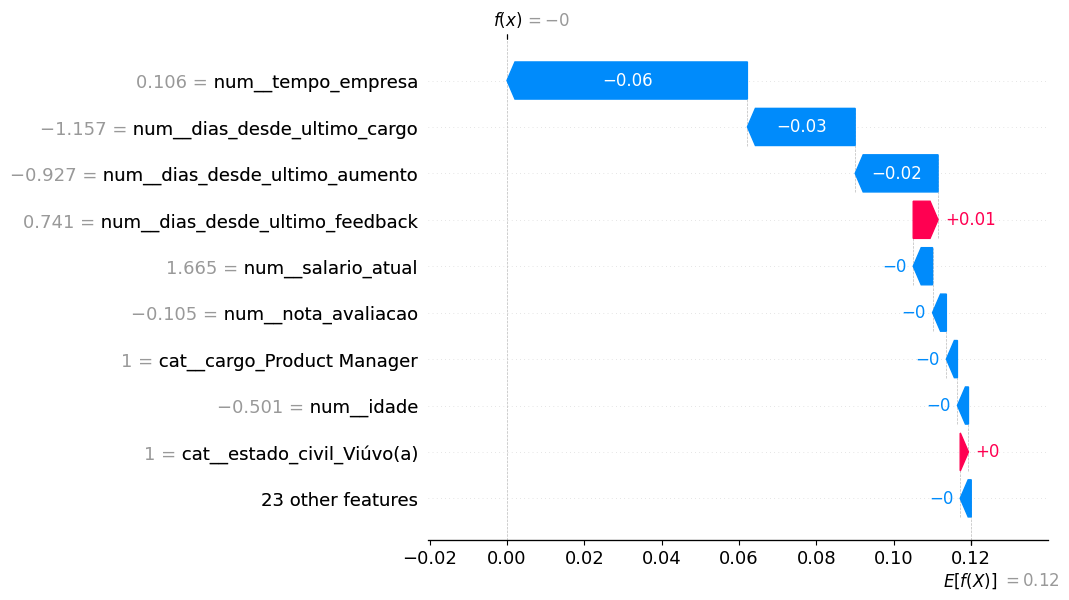

In [130]:
#plotar os shap values para um exemplo especifico
shap.plots.waterfall(shap_values_class[227], max_display=10)